In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [10]:
parameter_dict = {
    "test_id": "filtered-strict-subsample-combat-leiden", 
    "do_regress_out": True,
    "do_combat": True,
    "n_neighbors": [50],
    "n_pcs": [10],
    # "n_neighbors": [15, 15, 15, 50, 50, 50, 100, 100, 100],
    # "n_pcs": [5, 10, 15, 5, 10, 15, 5, 10, 15],
    "cluster_resolution": [.5, 1, 1.5, 2],
}

0it [00:00, ?it/s]

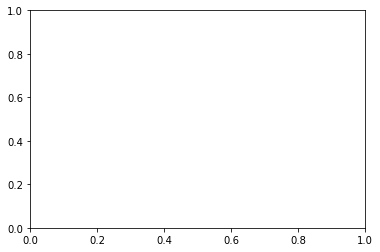

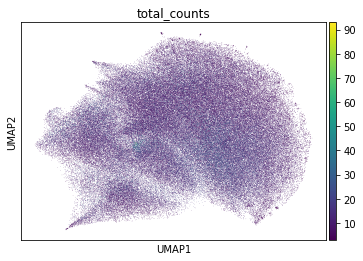

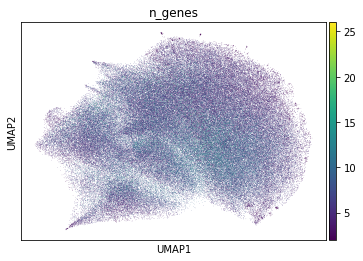

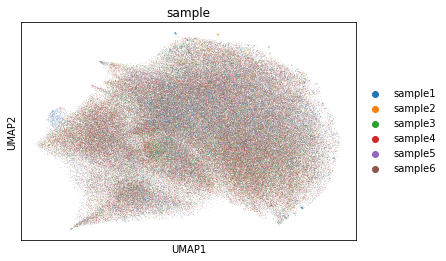

0it [00:00, ?it/s]

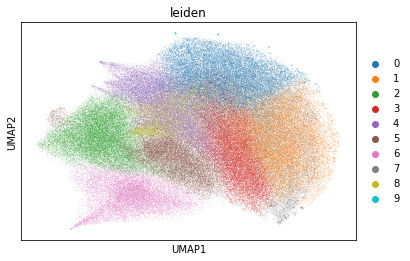

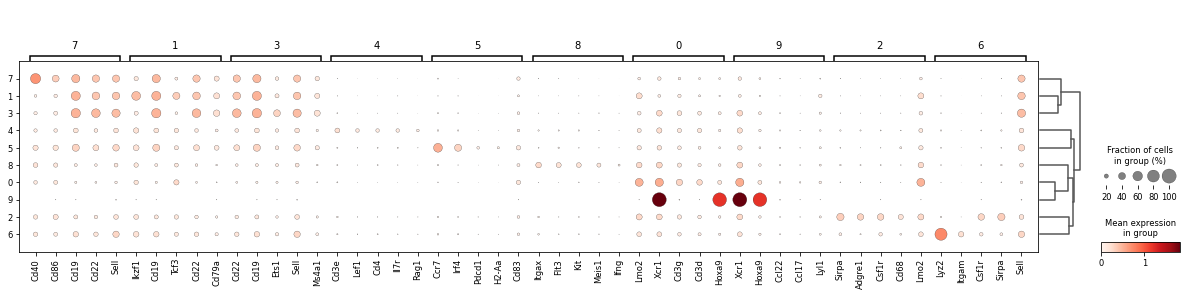

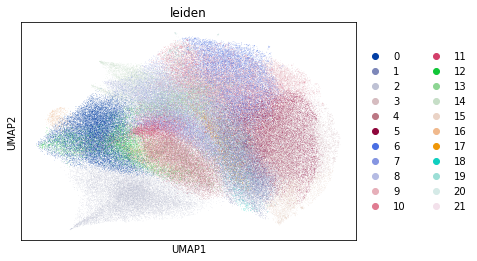

C:\Users\jiahao\.conda\envs\sc_38\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\jiahao\.conda\envs\sc_38\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\jiahao\.conda\envs\sc_38\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fra

ValueError: Incompatible observations. Dendrogram data has 10 categories but current groupby observation ['leiden'] contains 22 categories. Most likely the underlying groupby observation changed after the initial computation of `sc.tl.dendrogram`. Please run `sc.tl.dendrogram` again.'

In [11]:
# base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/'
base_path = 'Z:/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/'
output_path = os.path.join(base_path, 'output')
expr_path = os.path.join(base_path, 'expr')
test_path = os.path.join(output_path, parameter_dict['test_id'])
if not os.path.exists(test_path):
    os.mkdir(test_path)
    
cdata = sc.read_h5ad(os.path.join(expr_path, f'combined-filtered-strict-subsample.h5ad'))

# pp 
sc.pp.normalize_total(cdata)
sc.pp.log1p(cdata)
cdata.raw = cdata
sc.pp.scale(cdata)
cdata.layers['scaled'] = cdata.X.copy()

if parameter_dict['do_regress_out']:
    sc.pp.regress_out(cdata, ['total_counts'])
    cdata.layers['corrected'] = cdata.X.copy()

if parameter_dict['do_combat']:   
    sc.pp.combat(cdata, 'sample')
    cdata.layers['combat'] = cdata.X.copy()

# pca
sc.tl.pca(cdata, svd_solver='full')

# knn
for i, j in tqdm(enumerate(parameter_dict['n_neighbors'])):
    n_neighbors = parameter_dict['n_neighbors'][i]
    n_pcs = parameter_dict['n_pcs'][i]
    sc.pp.neighbors(cdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

    # umap
    sc.tl.umap(cdata)
    
    prefix = f"umap_{n_pcs}_{n_neighbors}"
    current_figure_path = os.path.join(test_path, prefix)
    if not os.path.exists(current_figure_path):
        os.mkdir(current_figure_path)
    sc.settings.figdir = current_figure_path
    
    fig, ax = plt.subplots()
    sc.pl.umap(cdata, color='total_counts', save=f'_total_counts.png')
    sc.pl.umap(cdata, color='n_genes', save=f'_n_genes.png')
    sc.pl.umap(cdata, color='sample', save=f'_sample.png')
    
    for a, b in tqdm(enumerate(parameter_dict['cluster_resolution'])):
        
        resolution = parameter_dict['cluster_resolution'][a]
        # leiden
        sc.tl.leiden(cdata, resolution=resolution)
        sc.pl.umap(cdata, color='leiden', save=f'_leiden_{resolution}.png')
        
        sc.tl.rank_genes_groups(cdata, 'leiden', method='t-test')
        sc.pl.rank_genes_groups_dotplot(cdata, n_genes=5, save=f"'_markers_{resolution}.png")

In [ ]:
genes = ['Cd3d', 'Cd8a', 'Cd4', 'Cd3', 'Foxp3', 
         'Il2ra', 'Il4', 'Ifng', 'Th17', 'Sell', 
         'Lef1', 'Ccr7', 'Itgam', 'Adgre1', 'Cd68', 
         'Csf1r', 'Lyz2', 'Itgax', 'Xcr1', 'Irf4', 
         'Irf8', 'Cd19', 'Cd22', 'Flt3', 'Il7r']